# TimeSeries_Classification_Practice

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import ntpath

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, plot_roc_curve, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from itertools import cycle
import warnings
warnings.simplefilter("ignore")

### <u>Question 1:</u> <br/>Time Series Classification Part 1: Feature Creation/Extraction
#### An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

##### (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which con- tains 6 time series and each time series has 480 consecutive values.
##### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data. <u>(I split the dataset in the following steps after cleaning and extracting the features, which is in (c)ii)</u>
##### (c) Feature Extraction
##### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
<u>i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).</u>
* 
#### Basic statistical features:
* mean
* median
* minimum/maximum/range
* standard deviation
* quantile/IQR
#### Time serie analysis related features:
* The Cross-Correlations (corelation between between each dimension d&d-1)
* The 𝑑 Auto-Correlations
* Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
* Parameters of the AR part
* Parameters of the MA part
#### Frequency domain related features:
* Discrete Wavelet Transform (DWT) / Discrete Fourier Transform (DFT)
* frequencies of the 𝑘 peaks in amplitude in the DFTs for the detrended 𝑑 dimensions
* 𝑘-quantiles of these DFTs

<u>ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.</u>

In [3]:
# go through all the files in the folder
file_path = "../data/AReM"
for root, dirs, files in os.walk(file_path):
    print(root)
    print(dirs)
    print(files)
    print ('--------------------------------')

../data/AReM
['bending1', 'walking', 'bending2', 'standing', 'sitting', 'lying', 'cycling']
['.DS_Store']
--------------------------------
../data/AReM/bending1
[]
['dataset7.csv', 'dataset6.csv', 'dataset4.csv', 'dataset5.csv', 'dataset1.csv', 'dataset2.csv', 'dataset3.csv']
--------------------------------
../data/AReM/walking
[]
['dataset7.csv', 'dataset6.csv', 'dataset4.csv', 'dataset5.csv', 'dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset10.csv', 'dataset11.csv', 'dataset13.csv', 'dataset12.csv', 'dataset15.csv', 'dataset14.csv', 'dataset8.csv', 'dataset9.csv']
--------------------------------
../data/AReM/bending2
[]
['dataset6.csv', 'dataset4.csv', 'dataset5.csv', 'dataset1.csv', 'dataset2.csv', 'dataset3.csv']
--------------------------------
../data/AReM/standing
[]
['dataset7.csv', 'dataset6.csv', 'dataset4.csv', 'dataset5.csv', 'dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset10.csv', 'dataset11.csv', 'dataset13.csv', 'dataset12.csv', 'dataset15.csv', 'dataset

In [4]:
# create a dictionary to show the samples of each activity clearly
file_dict = {}
for root, dirs, files in os.walk(file_path):    
    file_list=[]
    if not dirs:              
        file_list.extend(files)        
        file_dict[ntpath.basename(root)] = [files]
pd.set_option('max_colwidth', 200)
pd.DataFrame.from_dict(file_dict,orient='index',columns=['files'])

,files
bending1,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv]"
walking,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv, dataset10.csv, dataset11.csv, dataset13.csv, dataset12.csv, dataset15.csv, dataset14.csv, dataset..."
bending2,"[dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv]"
standing,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv, dataset10.csv, dataset11.csv, dataset13.csv, dataset12.csv, dataset15.csv, dataset14.csv, dataset..."
sitting,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv, dataset10.csv, dataset11.csv, dataset13.csv, dataset12.csv, dataset15.csv, dataset14.csv, dataset..."
lying,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv, dataset10.csv, dataset11.csv, dataset13.csv, dataset12.csv, dataset15.csv, dataset14.csv, dataset..."
cycling,"[dataset7.csv, dataset6.csv, dataset4.csv, dataset5.csv, dataset1.csv, dataset2.csv, dataset3.csv, dataset10.csv, dataset11.csv, dataset13.csv, dataset12.csv, dataset15.csv, dataset14.csv, dataset..."


In [5]:
# read the 88 samples one by one and name them by name['activity_dataseti.csv']
name=locals()

ls=[]
for key in file_dict.keys():
    for i in range(len(file_dict[key][0])):
        ls.append(str(key)+'_'+str(file_dict[key][0][i]))
        name[str(key)+'_'+str(file_dict[key][0][i])]=pd.read_csv('../data/AReM/'
                                                                 +key+'/'
                                                                 +file_dict[key][0][i],header=4,index_col=0)  

In [6]:
# see one of the samples to make sure the data is read correctly
name['cycling_dataset9.csv'][:10]

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
# Columns: time,,,,,,
0,41.67,0.47,17.67,2.87,14.50,2.06
250,42.00,2.12,9.67,6.34,14.75,2.49
500,35.75,1.79,13.75,3.03,18.50,4.09
750,34.25,4.02,17.75,1.09,16.25,3.70
1000,36.50,4.33,14.75,1.09,12.67,4.92
1250,40.50,1.66,10.75,6.14,18.75,1.48
1500,43.00,1.87,17.33,2.49,15.50,2.29
1750,38.25,1.92,14.00,0.00,17.67,1.25
2000,37.50,1.50,15.50,3.28,19.00,1.00


In [7]:
ls[:10]

['bending1_dataset7.csv',
 'bending1_dataset6.csv',
 'bending1_dataset4.csv',
 'bending1_dataset5.csv',
 'bending1_dataset1.csv',
 'bending1_dataset2.csv',
 'bending1_dataset3.csv',
 'walking_dataset7.csv',
 'walking_dataset6.csv',
 'walking_dataset4.csv']

In [8]:
# show an example to generate the statistical features for a sample
# make sure what features we are going to collect in each sample
name['cycling_dataset9.csv'].describe().rename(index={'25%':'1st_quart','50%':'median','75%':'3rd_quart'})

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,37.144833,2.419062,14.998479,2.849625,16.773521,2.822437
std,3.758904,1.643175,3.289537,1.715185,2.689291,1.637183
min,27.750000,0.000000,0.000000,0.000000,0.000000,0.000000
1st_quart,34.000000,1.250000,13.000000,1.580000,15.000000,1.580000
median,36.330000,1.880000,15.000000,2.500000,17.000000,2.590000
3rd_quart,40.500000,3.367500,17.250000,3.900000,18.750000,3.740000
max,44.670000,10.760000,24.750000,9.000000,23.000000,8.750000


In [9]:
# create the feature tables for all the 88 samples and sort it by the name of activity
ls_feature=['min','max','mean','median','std','1st_quart','3rd_quart']

for i in range(len(ls)):
    name['s_'+ls[i]]=pd.Series({'activity0':ls[i]})
    
    for j in range(1,7):
        idx=[item+str(j) for item in ls_feature]
        df=name[ls[i]].describe().rename(index={'25%':'1st_quart','50%':'median','75%':'3rd_quart'})
        
        name['s_'+str(j)]=pd.Series(df.loc[ls_feature].iloc[:,j-1].tolist(),index=idx,name=j)
        name['s_'+ls[i]]=name['s_'+ls[i]].append(name['s_'+str(j)])

In [10]:
# generate the target variable "activity"
df0=pd.DataFrame([name['s_'+item] for item in ls]).sort_values('activity0',ignore_index=True)
df0['activity']=df0['activity0'].map(lambda x:x.split('_')[0])
df0['activity1']=df0['activity0'].map(lambda x:x.split('_')[1])
df0

,activity0,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,...,3rd_quart5,min6,max6,mean6,median6,std6,1st_quart6,3rd_quart6,activity,activity1
0,bending1_dataset1.csv,37.25,45.00,40.624792,40.500,1.476967,39.25,42.0000,0.0,1.30,...,36.00,0.0,1.92,0.570583,0.430,0.582915,0.00,1.3000,bending1,dataset1.csv
1,bending1_dataset2.csv,38.00,45.67,42.812812,42.500,1.435550,42.00,43.6700,0.0,1.22,...,34.50,0.0,3.11,0.571083,0.430,0.601010,0.00,1.3000,bending1,dataset2.csv
2,bending1_dataset3.csv,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,...,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1,dataset3.csv
3,bending1_dataset4.csv,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,...,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1,dataset4.csv
4,bending1_dataset5.csv,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,...,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1,dataset5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,walking_dataset5.csv,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,...,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking,dataset5.csv
84,walking_dataset6.csv,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,...,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking,dataset6.csv
85,walking_dataset7.csv,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,...,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking,dataset7.csv
86,walking_dataset8.csv,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,...,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking,dataset8.csv


##### The task in (b): split train and test

In [11]:
# split test and train
Test0=df0[df0['activity0'].isin (['bending1_dataset1.csv','bending1_dataset2.csv',
                                 'bending2_dataset1.csv','bending2_dataset2.csv',
                                 'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv',
                                 'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv',
                                 'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv',
                                 'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv',
                                 'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv'])]

Test=Test0.drop(columns=['activity0','activity1'])
Test

,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,...,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std6,1st_quart6,3rd_quart6,activity
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
7,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
8,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
13,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
20,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling
21,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling
28,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363688,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying
35,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying
36,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying


In [12]:
Train0=df0[df0['activity0'].isin (['bending1_dataset1.csv','bending1_dataset2.csv',
                                 'bending2_dataset1.csv','bending2_dataset2.csv',
                                 'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv',
                                 'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv',
                                 'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv',
                                 'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv',
                                 'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv']) == False]

Train=Train0.drop(columns=['activity0','activity1'])
Train

,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,...,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std6,1st_quart6,3rd_quart6,activity
2,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1
3,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1
4,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1
5,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,bending1
6,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.00,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking
84,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking
85,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking
86,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking


In [13]:
# split X(time series features) and y(activity)
X_train=Train.drop(columns='activity')
X_test=Test.drop(columns='activity')

y_train=Train['activity']
y_test=Test['activity']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69, 42), (19, 42), (69,), (19,))

<u>iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.</u>

In [14]:
# Calculate/estimate the standard deeviation of each feature based on the training set
X_train.describe().loc['std']

min1          8.794295
max1          4.429182
mean1         4.917717
median1       4.956111
std1          1.758629
1st_quart1    5.731262
3rd_quart1    4.783645
min2          0.000000
max2          5.147841
mean2         1.600661
median2       1.436903
std2          0.902769
1st_quart2    0.952201
3rd_quart2    2.158258
min3          3.053869
max3          4.759853
mean3         3.863304
median3       3.845730
std3          0.996008
1st_quart3    4.145255
3rd_quart3    3.946023
min4          0.000000
max4          2.302408
mean4         1.179781
median4       1.149585
std4          0.473525
1st_quart4    0.842771
3rd_quart4    1.566564
min5          5.368786
max5          5.449726
mean5         5.120513
median5       5.267414
std5          1.057973
1st_quart5    5.543882
3rd_quart5    4.957231
min6          0.051766
max6          2.540166
mean6         1.171306
median6       1.104626
std6          0.519377
1st_quart6    0.774233
3rd_quart6    1.550218
Name: std, dtype: float64

In [15]:
# using Bootstrap algorithm to calculate the confidence internval of each standard deviation
ls_std=[]
for i in X_train.columns:
    name[i+'_std'] =bs.bootstrap(np.array(X_train.loc[:,i]), stat_func=bs_stats.std, alpha=0.1)
    ls_std.append([i,str(name[i+'_std'])])

In [16]:
df_std=pd.DataFrame(ls_std,columns=['time-domain_feature','std0'])
df_std['std']=df_std['std0'].map(lambda x:x.split('(')[0])
df_std['confidence_internval']='('+df_std['std0'].map(lambda x:x.split('(')[1])
df_std.drop(columns='std0',inplace=True)

In [17]:
df_std

,time-domain_feature,std,confidence_internval
0,min1,8.730335507644275,"(7.5021691404449005, 9.998725093778814)"
1,max1,4.396968872496197,"(3.434133864267351, 5.564826644083209)"
2,mean1,4.88195084823011,"(4.380813387518061, 5.466821254092361)"
3,median1,4.920065980691552,"(4.400117431830723, 5.549250249390582)"
4,std1,1.7458389584050433,"(1.5560341828624382, 1.9612977745769629)"
5,1st_quart1,5.68957961026708,"(5.2106001485006574, 6.254733273606632)"
6,3rd_quart1,4.748854525045172,"(3.9983757120494188, 5.596404458177738)"
7,min2,0.0,"(0.0, 0.0)"
8,max2,5.110402070852341,"(4.73846425261332, 5.6043054660371)"
9,mean2,1.5890192093363118,"(1.4509584282823427, 1.7882955824637767)"


<u>iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).</u>

In [18]:
# Fistly, using the standard deviation of each feature to make a initial guess
df_std.sort_values('std',ascending=False).head(15)

,time-domain_feature,std,confidence_internval
0,min1,8.730335507644275,"(7.5021691404449005, 9.998725093778814)"
5,1st_quart1,5.68957961026708,"(5.2106001485006574, 6.254733273606632)"
33,1st_quart5,5.5035623447419635,"(4.229095450641219, 6.969083663000728)"
29,max5,5.41009125399947,"(4.449277727427976, 6.5565320815858925)"
28,min5,5.3297396682893465,"(3.8233419882302933, 7.134559822455795)"
31,median5,5.229104952602789,"(3.9664045885484427, 6.769662326734892)"
8,max2,5.110402070852341,"(4.73846425261332, 5.6043054660371)"
30,mean5,5.083272562258776,"(3.8773630879868577, 6.502985898436392)"
34,3rd_quart5,4.9211774745781005,"(3.8036929108174062, 6.2402949403126255)"
3,median1,4.920065980691552,"(4.400117431830723, 5.549250249390582)"


<u>From the table above, we can see that:</u><br/>"max" appears 4 times; <br/>"1st_quart" appears 3 times; <br/>"min" appears 2 times; <br/>"3rd_quart" appears 2 times,<br/>"median" appears 2 times. <br/>**And for all of the features above, we choose 3 features which appear more often in higher position(higher std). Thus, we can make initial guess that ("max", "1st_quart", "min", "3rd_quart", "median") all can be important time-domain features.**<br/>
**Reason:**
* __The higher "Standard Deviation" is, the more different this feature will be in different activities. In other words, if a feature's value is highly different in different activitis, it may result in the high deviation of the data. <br/> And if a feature's value is highly different in different activitis, we may identify an activity by the value of this feature more easily, which means it may be a good predictor/important feature to predict which activity the person is doing.__

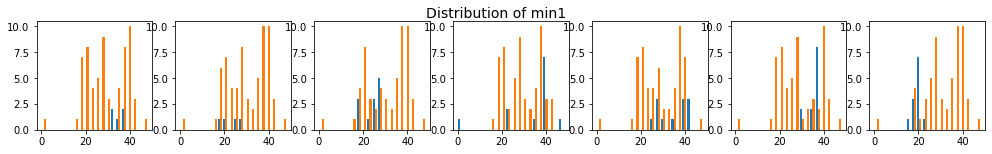

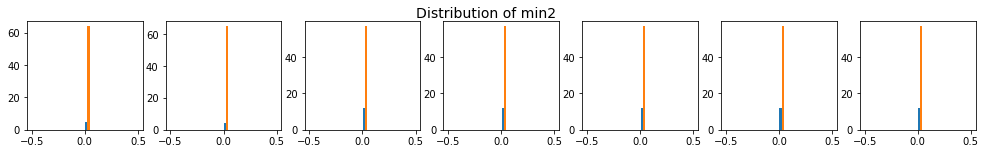

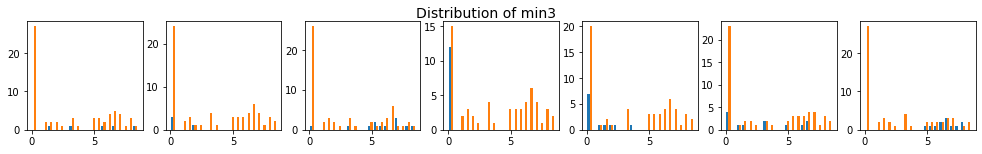

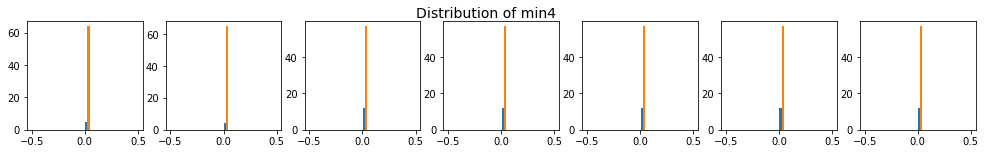

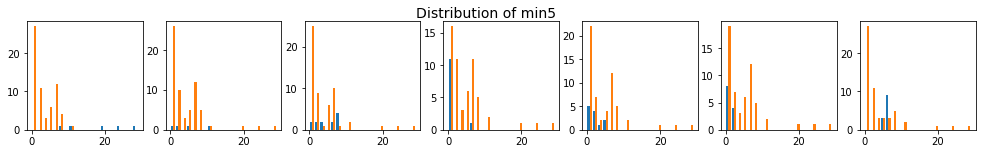

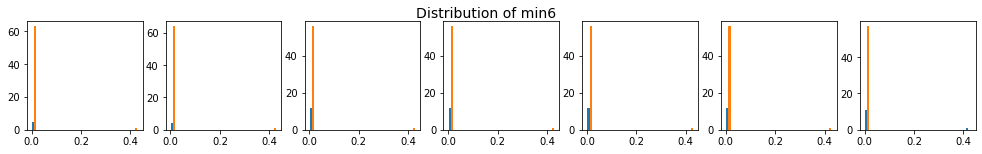

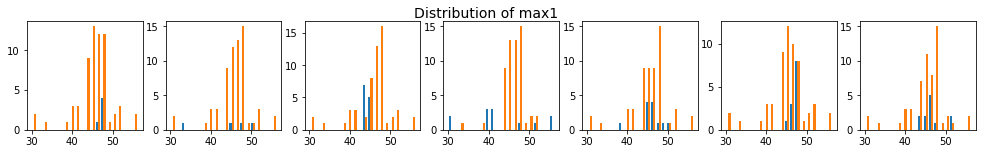

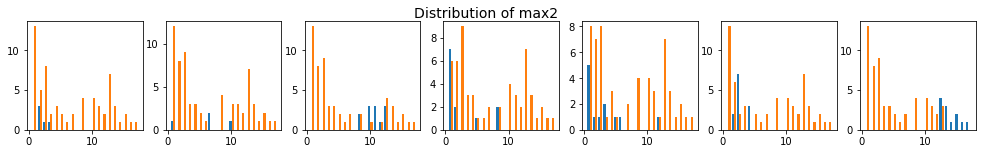

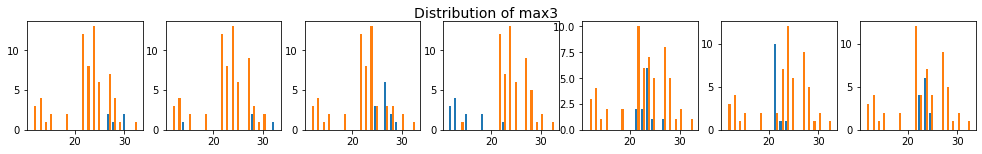

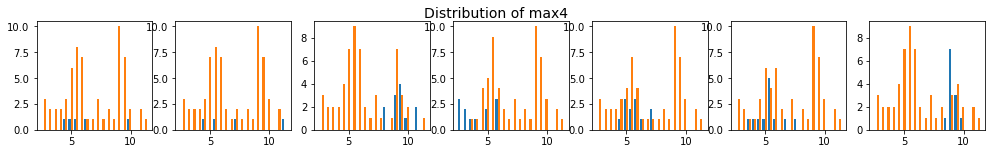

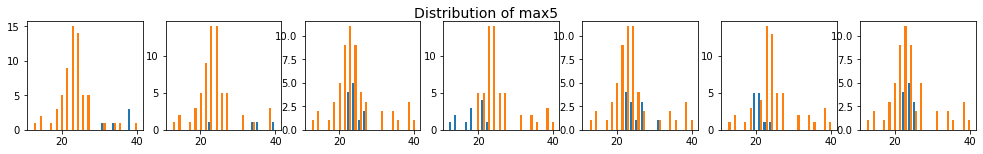

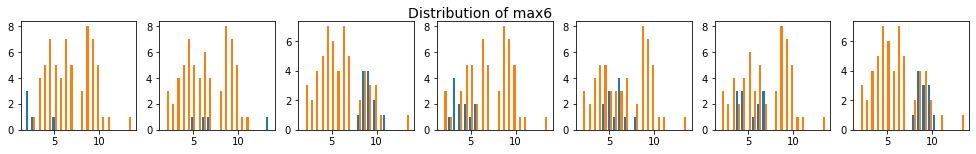

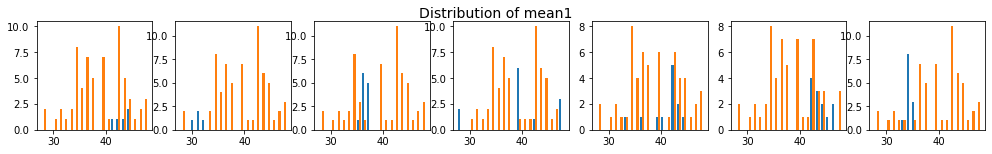

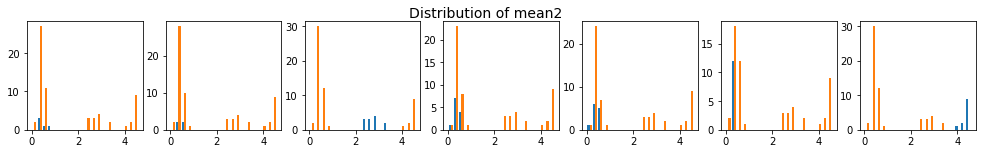

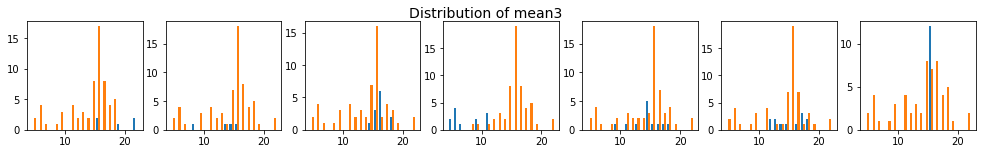

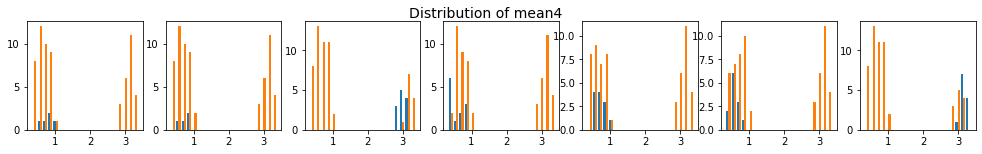

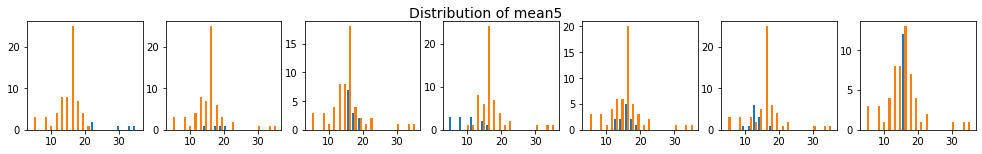

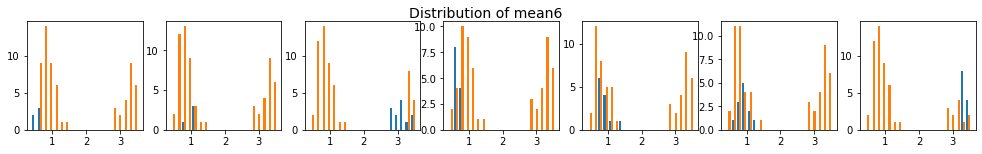

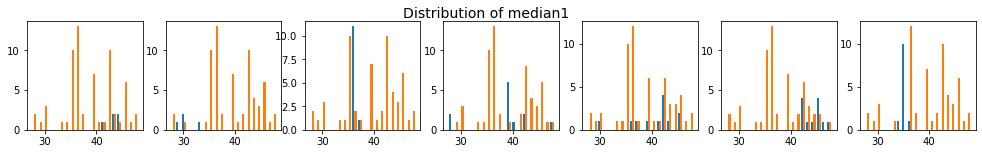

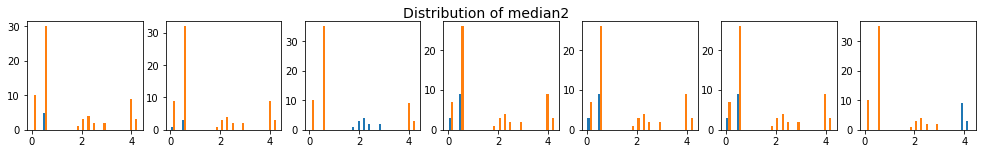

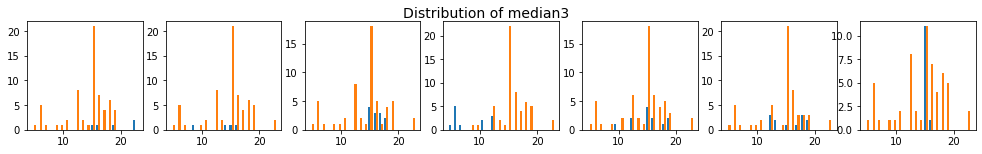

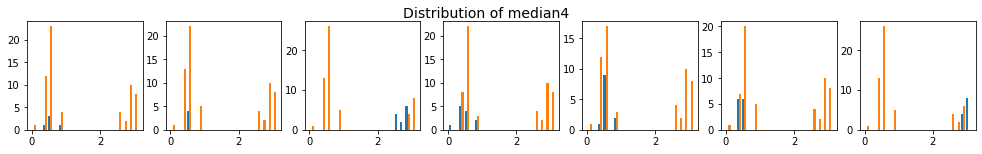

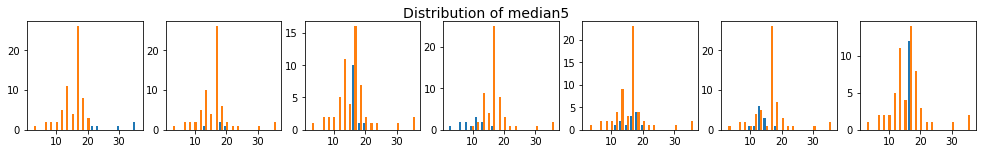

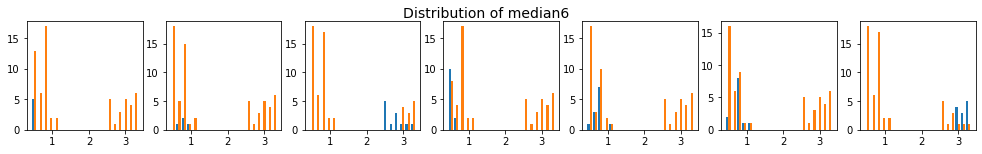

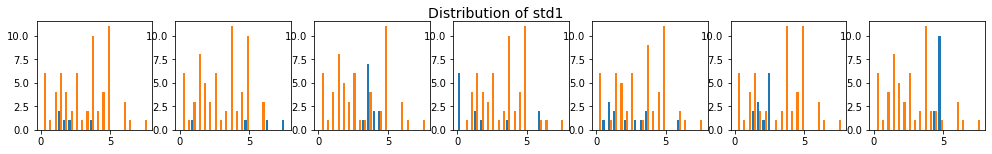

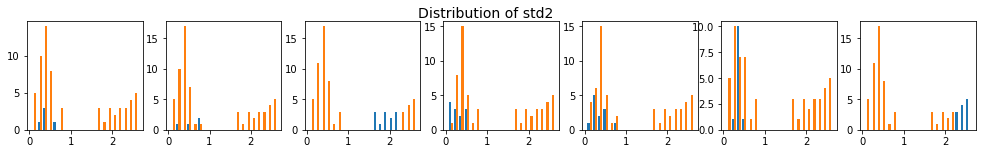

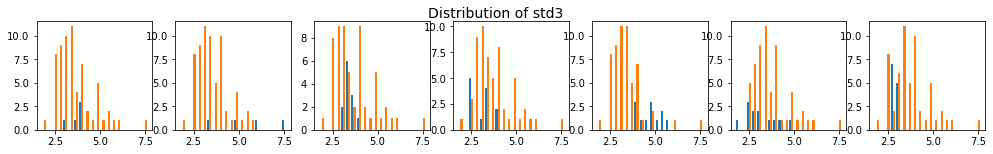

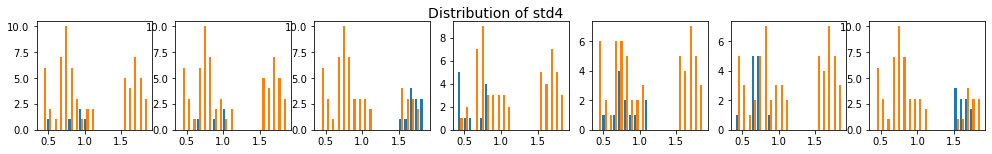

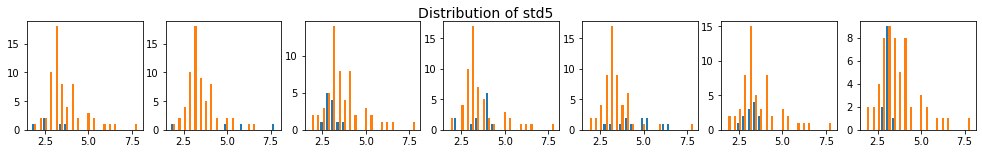

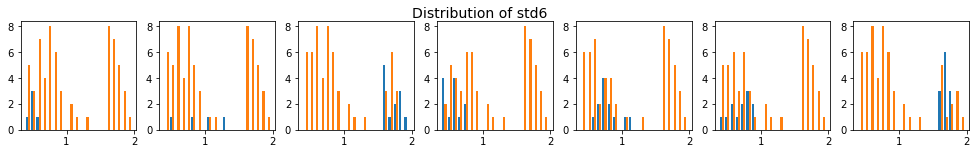

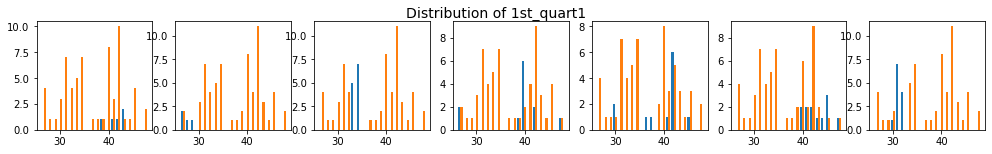

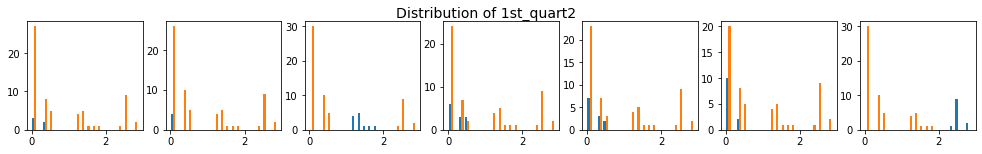

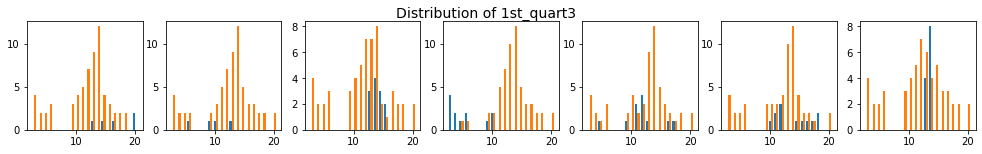

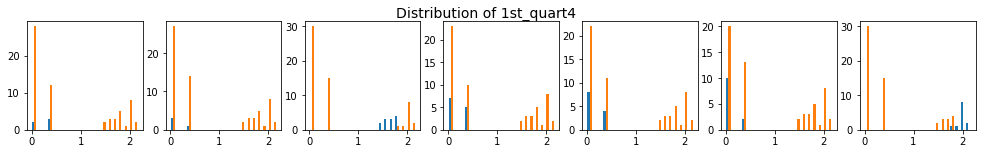

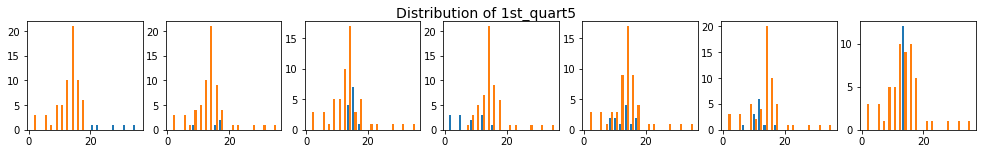

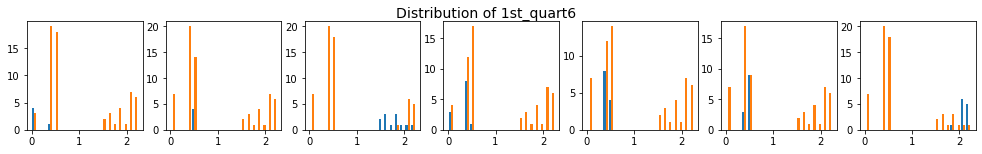

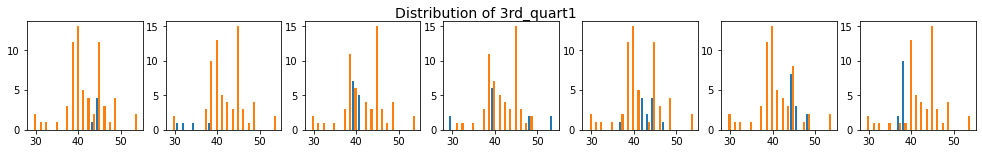

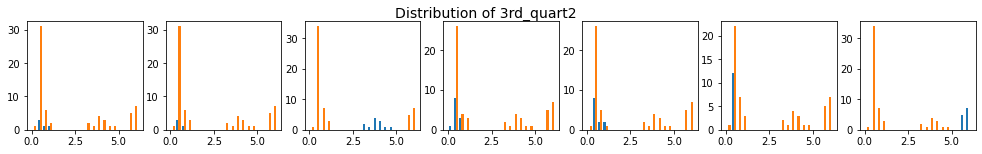

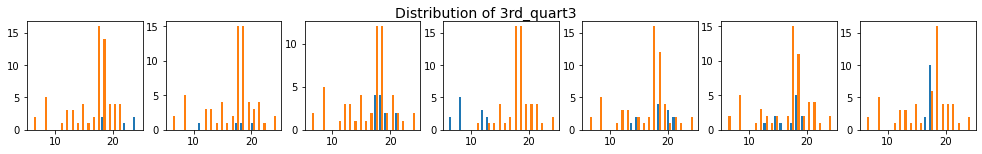

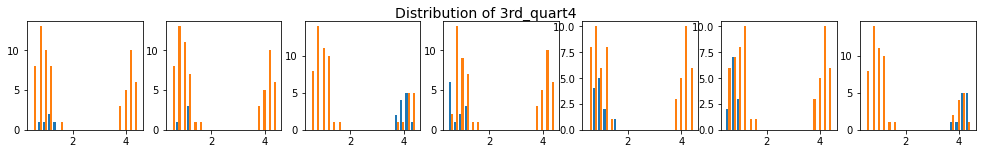

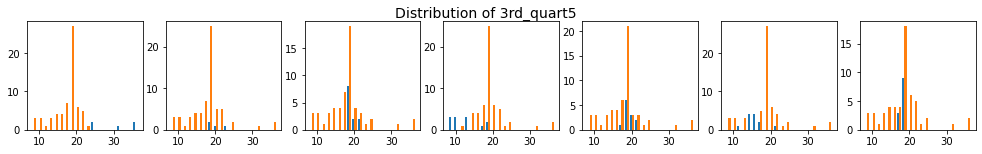

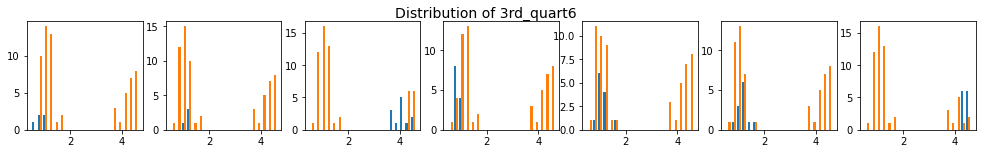

In [19]:
# To make a further justification, we can plot the distribution of each time-domain feature. 
# And compare each feature between one activity and all the others to see whether it can distinguish this activity
# i.e. plot the distribution of "min1" with data belonging to "bending1" and data belonging to all other activities
n_bins = 20
act=Train['activity'].unique()

for f in ls_feature:
    for i in range(1,7):
        df=Train[[f+str(i),'activity']]
        fig,(ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 7,figsize=(17,2))
        fig.suptitle('Distribution of '+f+str(i),fontsize=14)
        
        for j in range(7):
            name['ax'+str(j)].hist([df[df['activity']==act[j]].iloc[:,0],
                                    df[df['activity']!=act[j]].iloc[:,0]], bins=n_bins)

* <u>__From the plot, if the overlap between "blue" and "orange" is small, we can say the feature is good to identify an activity. And according to the figures, "max", "min", "1st_quart", "3rd_quart" can be the best features to identify an activity.__</u>

In [20]:
# In addition, applying SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X_train,y_train)

In [21]:
dfscores=pd.DataFrame([X_train.columns,fit.scores_],index=['Feaeture','Score']).T
dfscores.sort_values('Score',ascending=False).head(15)

,Feaeture,Score
28,min5,327.684
8,max2,233.5
13,3rd_quart2,151.968
14,min3,139.011
9,mean2,114.057
33,1st_quart5,110.444
10,median2,103.477
0,min1,91.9207
31,median5,87.671
30,mean5,86.9174


* __Considering result of "SelectKBest" and "Standard Deviation" at the same time, "min" and "max" appear most and have the highest rank, "3rd_quart" seems better than "1st_quart" because they both appear twice in "Standard Deviation" but "3rd_quart" appears more in "SelectKBest".<br/> <u>Thus, we can make conclusion that ("max", "min", "3rd_quart") are the three most important time-domain features.</u>__

---

### <u>Question 4:</u> <br/> Time Series Classification Part 2: Binary and Multiclass Classification
Important Note: You will NOT submit this part with Homework 3. How- ever, because it uses the features you extracted from time series data in Homework 3, and because some of you may want to start using your fea- tures to build models earlier, you are provided with the instructions of the next programming assignment. Thus, you may want to submit the code for Homework 3 with Homework 4 again, since it might need the feature creation code. Also, since this part involves building various models, you are strongly recommended to start as early as you can.


##### (a) Binary Classification Using Logistic Regression<br/>

<u>i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).</u>

In [22]:
df_bending1=Train[['min1','max1','3rd_quart1',
                   'min2','max2','3rd_quart2',
                   'min6','max6','3rd_quart6','activity']].copy()

df_bending1['activity1'] = df_bending1['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
df_bending1.drop(columns='activity',inplace=True)
df_bending1[:15]

,min1,max1,3rd_quart1,min2,max2,3rd_quart2,min6,max6,3rd_quart6,activity1
2,35.00,47.40,45.0000,0.0,1.70,0.5000,0.0,1.79,0.9400,1
3,33.00,47.75,45.0000,0.0,3.00,1.1200,0.0,2.18,1.0000,1
4,33.00,45.75,42.7500,0.0,2.83,0.7100,0.0,1.79,0.5000,1
5,37.00,48.00,45.0000,0.0,1.58,0.5000,0.0,5.26,0.8700,1
6,36.25,48.00,44.6700,0.0,1.50,0.5000,0.0,2.96,0.8300,1
9,21.00,50.00,34.5000,0.0,9.90,0.8225,0.0,13.61,1.3000,1
10,27.50,33.00,30.2700,0.0,1.00,0.4700,0.0,6.40,0.9400,1
11,19.00,45.50,38.0000,0.0,6.40,0.5000,0.0,6.73,1.3000,1
12,25.00,47.50,31.8125,0.0,6.38,0.5000,0.0,4.92,1.3000,1
14,27.00,45.00,40.2500,0.0,10.47,3.8700,0.0,8.99,3.7700,0


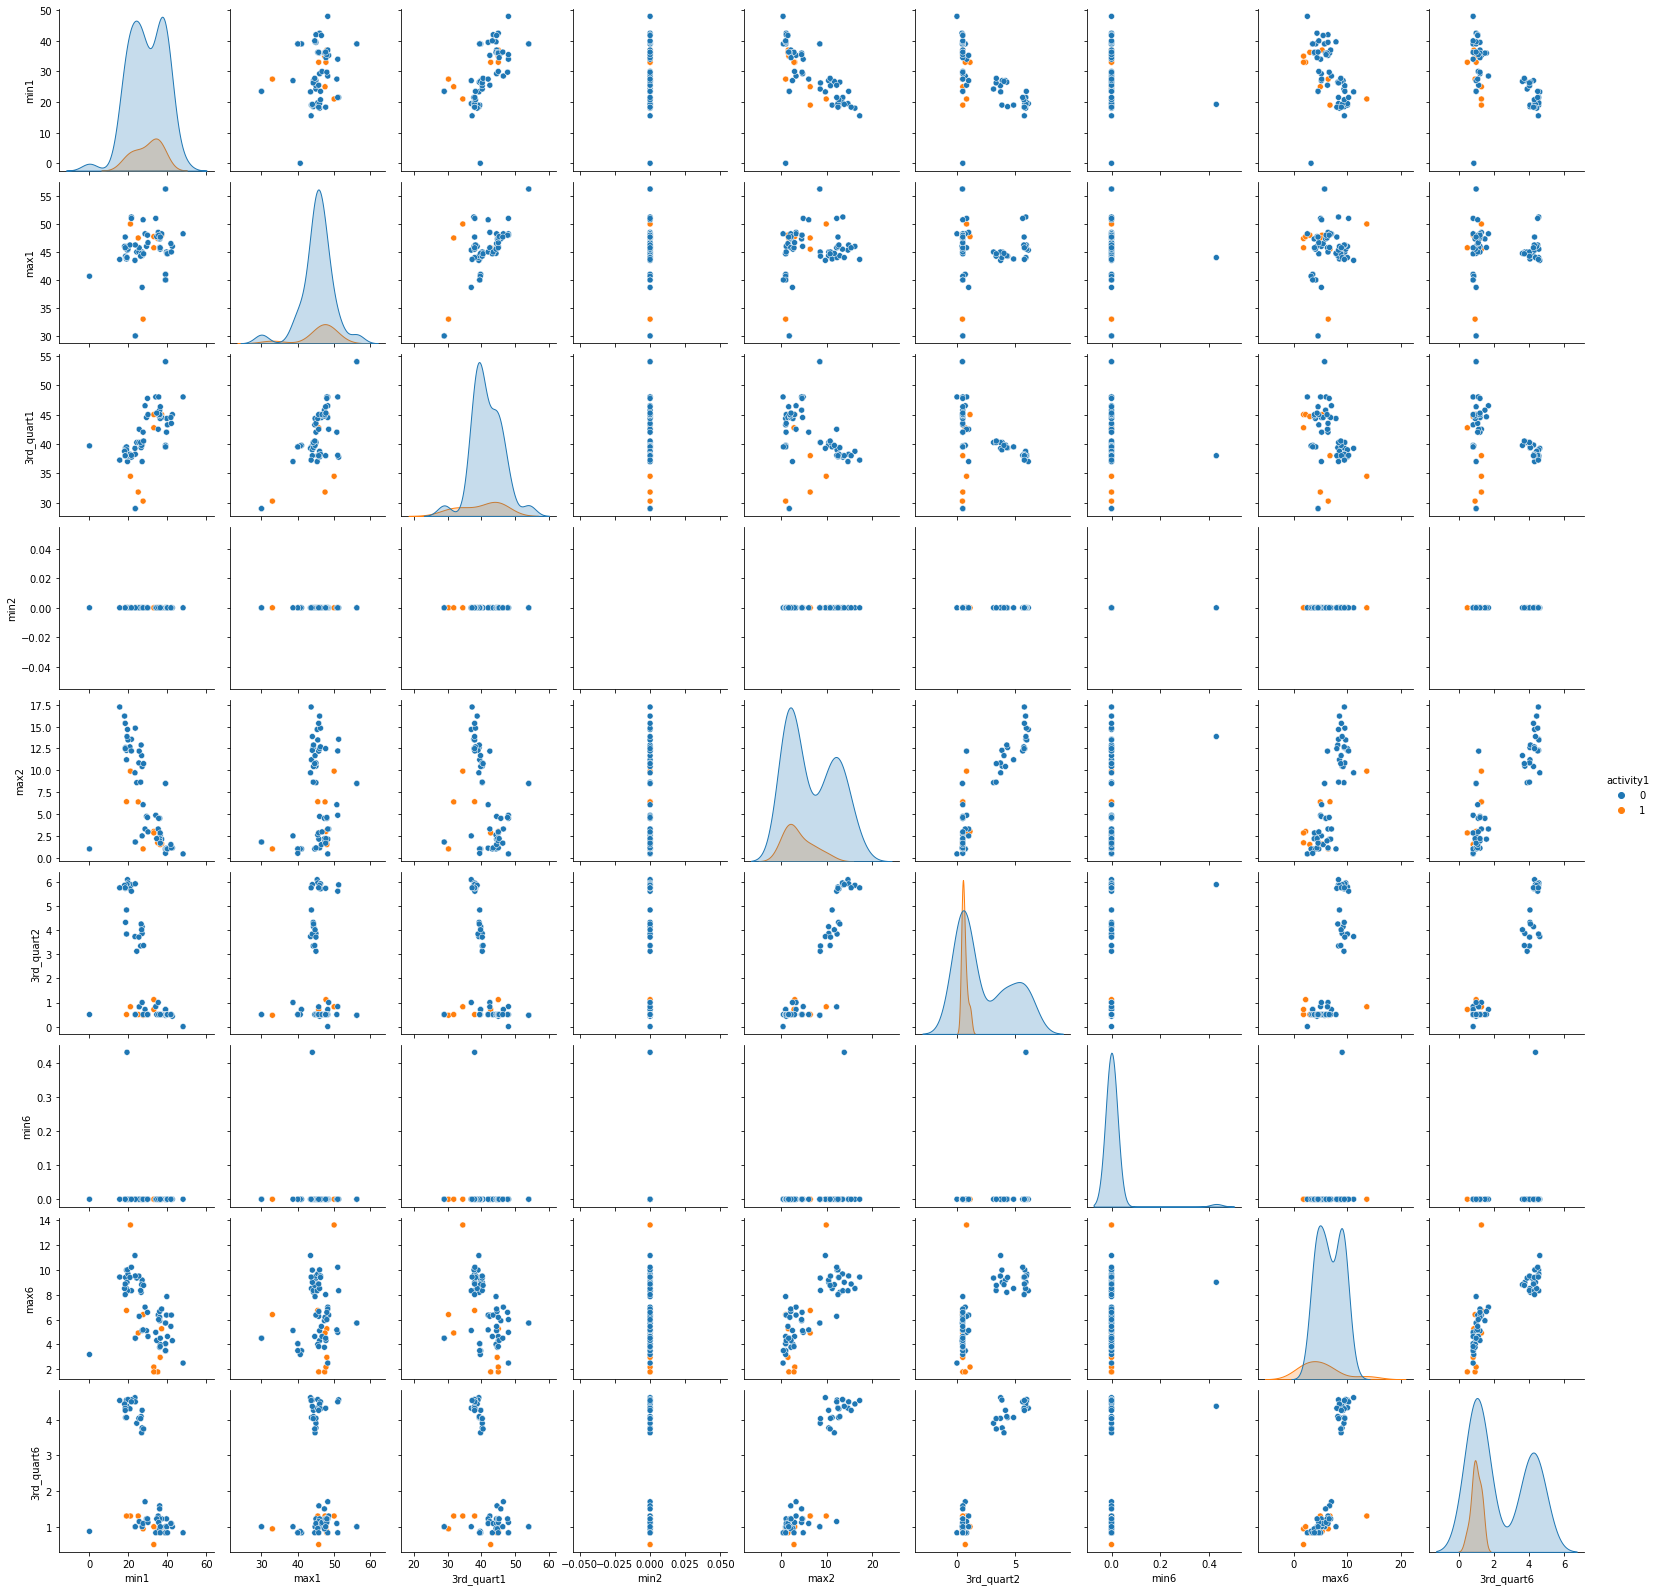

In [23]:
sns.pairplot(df_bending1, hue='activity1')


<u>ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?<br/></u>


In [24]:
# generate new dataset with each instance having 12 time series
ls_2 = []
for i in range(len(ls)):
    d1 = name[ls[i]][:240].copy()
    d2 = name[ls[i]][240:].copy()
    d1.index=range(240)
    d2.index=range(240)

    name[ls[i]+'12'] = pd.concat([d1,d2],axis=1)
    name[ls[i]+'12'].columns = ['x_'+str(i) for i in range(1,13)]
    ls_2.append(str(ls[i]+'12'))

In [25]:
# extract the time domain features for the new dataset
for i in range(len(ls)):
    name['s_'+ls[i]+'12']=pd.Series({'activity0':ls[i]})
    df=name[ls[i]+'12'].describe().rename(index={'25%':'1st_quart','50%':'median','75%':'3rd_quart'})
    
    for j in range(1,13):
        idx=[item+str(j) for item in ls_feature]
        
        name['s_'+str(j)+'12']=pd.Series(df.loc[ls_feature].iloc[:,j-1].tolist(),index=idx,name=j)
        name['s_'+ls[i]+'12']=name['s_'+ls[i]+'12'].append(name['s_'+str(j)+'12'])

In [26]:
# generate the target variable "activity"
df0_12=pd.DataFrame([name['s_'+item+'12'] for item in ls]).sort_values('activity0',ignore_index=True)
df0_12['activity']=df0['activity0'].map(lambda x:x.split('_')[0])
df0_12['activity1']=df0['activity0'].map(lambda x:x.split('_')[1])

In [27]:
# genarate Train set
Train02=df0_12[df0_12['activity0'].isin(['bending1_dataset1.csv','bending1_dataset2.csv',
                                     'bending2_dataset1.csv','bending2_dataset2.csv',
                                     'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv',
                                     'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv',
                                     'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv',
                                     'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv',
                                     'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv']) == False]

Train2=Train02.drop(columns=['activity0','activity1'])
Train2

,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,...,1st_quart11,3rd_quart11,min12,max12,mean12,median12,std12,1st_quart12,3rd_quart12,activity
2,36.50,46.50,44.057167,44.500,1.556971,43.2500,45.0000,0.0,1.50,0.381042,...,33.0000,36.2500,0.00,1.50,0.388333,0.000,0.478528,0.0000,0.7100,bending1
3,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,0.0,3.00,0.673292,...,28.7500,33.7500,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700,bending1
4,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,0.0,2.83,0.623083,...,28.3100,30.5625,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000,bending1
5,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,0.0,1.30,0.250042,...,22.5000,23.7500,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100,bending1
6,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,0.0,1.30,0.378667,...,21.0000,23.5000,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,22.33,46.00,34.966250,35.500,4.733014,32.0000,38.7500,0.0,12.68,4.207958,...,14.0000,18.5000,0.00,9.39,3.430208,3.350,1.647979,2.1700,4.4400,walking
84,21.50,45.67,34.737042,35.500,4.276717,32.0000,37.7500,0.0,12.21,4.217333,...,14.5000,18.2500,0.00,10.21,3.225917,3.085,1.665326,2.0500,4.3500,walking
85,18.33,45.00,33.886458,34.375,5.143776,30.4575,37.5000,0.0,12.44,4.332208,...,13.6275,18.2500,0.00,8.01,3.274750,2.955,1.670593,2.0500,4.4375,walking
86,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,0.0,12.38,4.257750,...,13.9375,18.2500,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450,walking


In [28]:
df_bending2=Train2[['min1','max1','3rd_quart1',
                    'min2','max2','3rd_quart2',
                    'min6','max6','3rd_quart6',
                    'min7','max7','3rd_quart7',
                    'min8','max8','3rd_quart8',
                    'min12','max12','3rd_quart12','activity']].copy()

df_bending2['activity1'] = df_bending2['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
df_bending2.drop(columns='activity',inplace=True)
df_bending2[:15]

,min1,max1,3rd_quart1,min2,max2,3rd_quart2,min6,max6,3rd_quart6,min7,max7,3rd_quart7,min8,max8,3rd_quart8,min12,max12,3rd_quart12,activity1
2,36.50,46.50,45.0000,0.0,1.50,0.5000,0.0,1.79,1.0000,35.00,47.40,45.0000,0.0,1.70,0.5000,0.0,1.50,0.7100,1
3,33.75,47.75,45.2500,0.0,3.00,1.0000,0.0,1.53,1.2200,33.00,46.00,44.5000,0.0,2.86,1.2275,0.0,2.18,0.8700,1
4,33.00,45.75,44.2500,0.0,2.83,0.8300,0.0,1.79,0.7100,39.25,43.67,42.0000,0.0,1.12,0.5000,0.0,1.50,0.5000,1
5,39.00,48.00,45.0000,0.0,1.30,0.5000,0.0,5.26,1.1200,37.00,46.50,43.0000,0.0,1.58,0.5000,0.0,4.06,0.7100,1
6,36.67,45.00,44.5000,0.0,1.30,0.5000,0.0,2.28,0.8300,36.25,48.00,44.7500,0.0,1.50,0.5000,0.0,2.96,0.8300,1
9,21.00,50.00,42.0000,0.0,9.90,0.5000,0.0,13.61,2.0500,27.00,36.00,33.7500,0.0,1.87,1.2275,0.0,6.02,0.9400,1
10,29.00,33.00,31.5000,0.0,1.00,0.5000,0.0,6.40,0.9400,27.50,30.00,29.5000,0.0,0.87,0.4700,0.0,1.50,0.9400,1
11,19.00,39.25,36.0000,0.0,4.33,0.8050,0.0,6.73,1.2200,20.00,45.50,42.0000,0.0,6.40,0.5000,0.0,5.61,1.3000,1
12,25.00,47.50,39.3725,0.0,6.38,0.8300,0.0,4.71,1.2500,25.00,33.00,29.0000,0.0,2.18,0.4700,0.0,4.92,1.4100,1
14,29.67,44.00,40.0000,0.0,10.47,4.0975,0.0,8.38,3.5625,27.00,45.00,40.5750,0.0,9.49,3.6700,0.0,8.99,4.0825,0


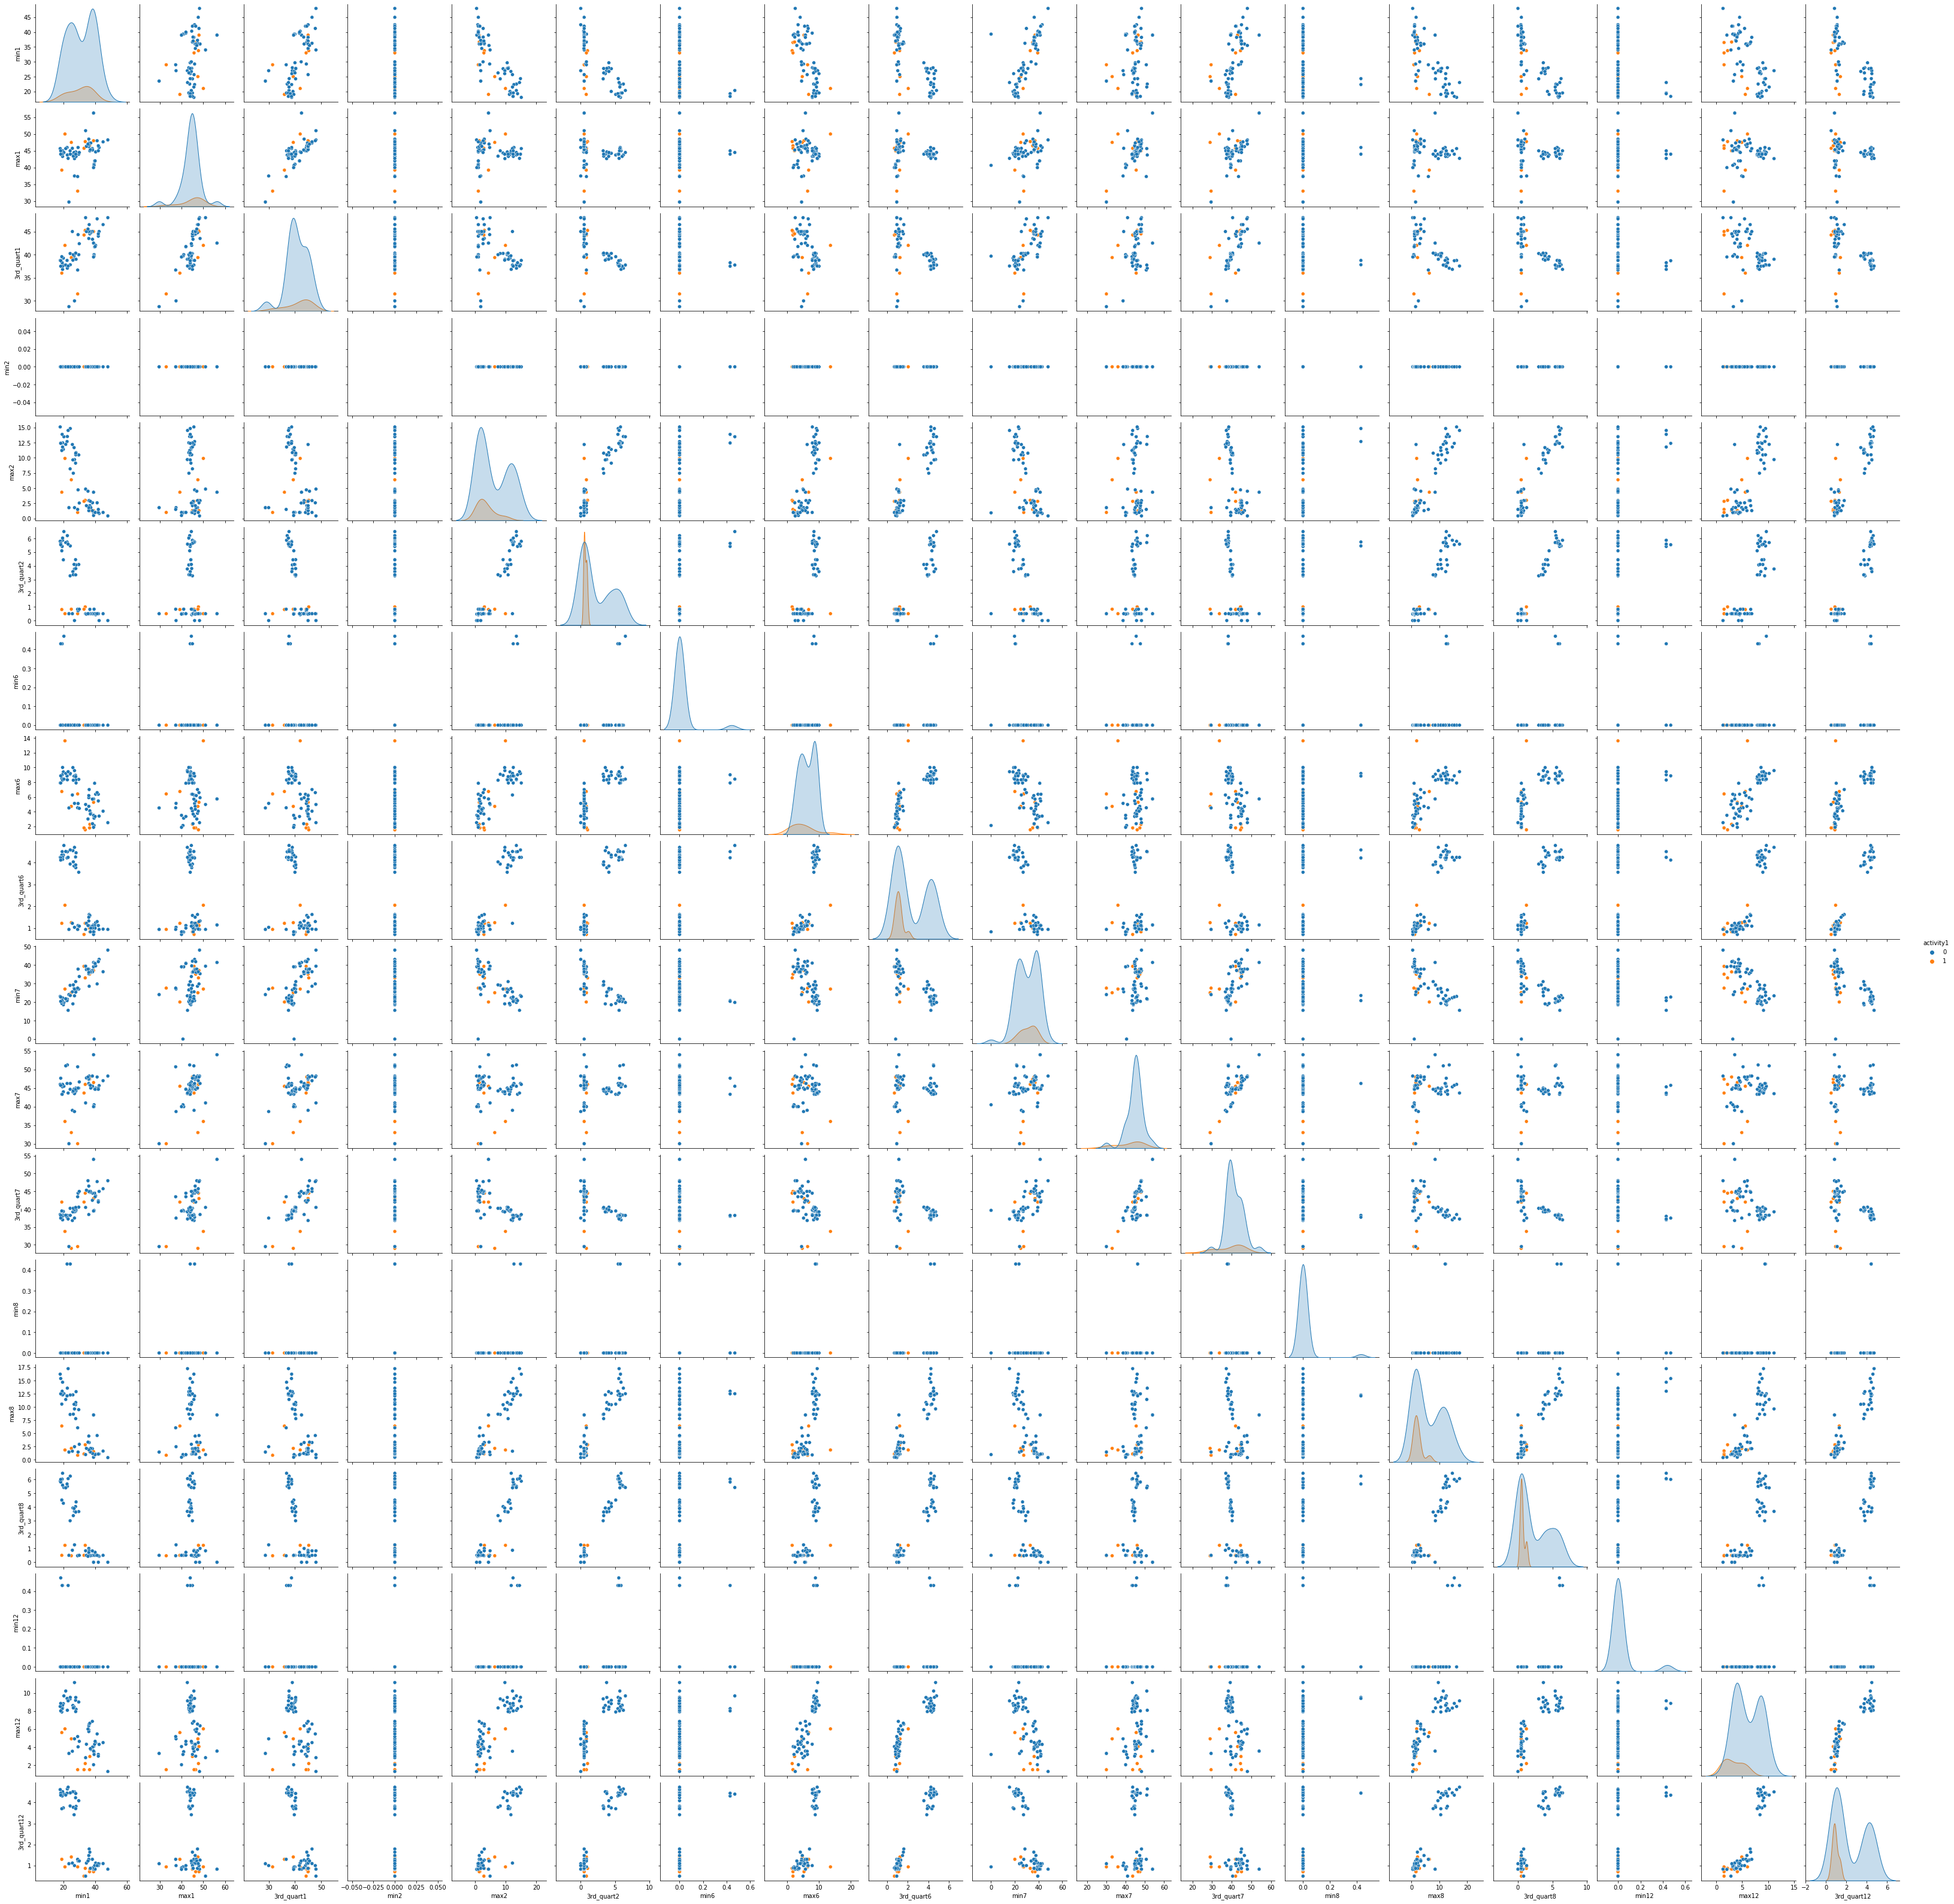

In [29]:
sns.pairplot(df_bending2, hue='activity1')

* __According to the two plot above, there seems not too much differences.__

<u>iii. Break each time series in your training set into $l ∈$ {$1, 2, . . . , 20$} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the $p-values$ for your logistic regression parameters in each model corresponding to each value of $l$ and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using $sklearn.feature selection$ or $glm$ in R. Use 5-fold cross-validation to determine the best value of the pair $(l, p)$, where $p$ is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.</u>

In [30]:
# define a function to generate Train set with "l" cut
def l_train(l):
    
    # the number of each group
    n = math.floor(480/l)
    n1 = 480 - n*(l-1)
    ln = [n]*(l-1)
    ln.append(n1)
    
    ls_ = []
    for csv in range(len(ls)):
        name['s_'+ls[csv]+'l']=pd.Series({'activity0':ls[csv]})
        
        x = 0
        for i in range(l):
            # divide each instance into l parts
            name['d' + str(i)] = name[ls[csv]][x : (x + ln[i])].copy()
            name['d' + str(i)].index = range(ln[i])
            df=name['d' + str(i)].describe().rename(index={'25%':'1st_quart','50%':'median','75%':'3rd_quart'})
            
            # generate 6*6 time domain features for each part 
            # and append it to the series of this instance
            for j in range(1,7):
                idx=[item+str(i+1)+str(j) for item in ls_feature] # minj, maxj, meanj...
                name['s_'+str(i+1)+str(j)]=pd.Series(df.loc[ls_feature].iloc[:,j-1].tolist(),index=idx,name=j)
                name['s_'+ls[csv]+'l']=name['s_'+ls[csv]+'l'].append(name['s_'+str(i+1)+str(j)])
                
            x += ln[i]

    # generate the whole dataset
    df0_l=pd.DataFrame([name['s_'+ item +'l'] for item in ls]).sort_values('activity0',ignore_index=True)
    df0_l['activity']=df0['activity0'].map(lambda x:x.split('_')[0])
    df0_l['activity1']=df0['activity0'].map(lambda x:x.split('_')[1])
    
    # get the train
    Train0_l=df0_l[df0_l['activity0'].isin(['bending1_dataset1.csv','bending1_dataset2.csv',
                                     'bending2_dataset1.csv','bending2_dataset2.csv',
                                     'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv',
                                     'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv',
                                     'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv',
                                     'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv',
                                     'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv']) == False]

    Train_l=Train0_l.drop(columns=['activity0','activity1'])
    return Train_l

In [31]:
# def a function to extract the specific time series with specific features we want
def ts(df, ls_n, ls_f):
    lss=[str(i) for i in ls_n]
    # filter the columns' name according to the input list
    col = df.columns.tolist()
    col_1 = [i for i in col if i.endswith(tuple(lss))]
    co = [i for i in col_1 if i.startswith(tuple(ls_f))]
    co.append('activity')
    
    # extract the columns
    return df[co].copy()

In [32]:
# find the best pair of (l, p)
# l = [1, 2,...,20]
l = range(1,21)

# the time series we want to extract from each instance
ls_n = [1, 2, 6]

# the time-domain features we want to extract 
ls_f = ['min', 'max', '3rd_quart']

ls_select=[]
model = LogisticRegression()
for i in l:
    dfl = l_train(i)
    dft = ts(dfl, ls_n, ls_f)
    dft['activity1'] = dft['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
    dft.drop(columns = 'activity',inplace = True)
        
    Xt = dft.drop(columns='activity1').copy()
    yt = dft['activity1'].copy()
        
    # p should be less than l
    p = list(range(1, i+1))
    for j in p:
        selector = RFECV(model, step = j, cv = 5)
        selector = selector.fit(Xt, yt)
        
        score = selector.cv_results_['mean_test_score'].mean()
        features = Xt.columns[np.where(selector.support_ == True)].tolist()
        
        ls_select.append([(i,j), score, selector.n_features_, features])

In [33]:
df_select = pd.DataFrame(ls_select, columns=['(l,p)', 'score', 'n_features_', 'features'])
df_best = df_select.sort_values('score', ascending = False).head()
df_best

,"(l,p)",score,n_features_,features
11,"(5, 2)",0.919780,7,"[max16, max21, max22, min31, max36, max46, max56]"
3,"(3, 1)",0.916280,7,"[max11, max12, min21, max26, max31, 3rd_quart31, max36]"
17,"(6, 3)",0.912551,18,"[min11, max16, max21, max22, max26, min31, 3rd_quart31, 3rd_quart32, max36, min41, max46, min51, max51, 3rd_quart51, max56, max61, max62, max66]"
15,"(6, 1)",0.911559,15,"[max16, max21, max22, 3rd_quart22, max26, min31, 3rd_quart31, 3rd_quart32, max36, max46, min51, 3rd_quart51, max56, max61, max66]"
10,"(5, 1)",0.910379,26,"[min11, max11, 3rd_quart11, max12, max16, 3rd_quart16, min21, max21, max22, max26, min31, max31, 3rd_quart31, max32, 3rd_quart32, max36, min41, max41, 3rd_quart41, max42, max46, 3rd_quart46, max51..."


* __The best pair of $(l, p)$ is $(5, 2)$__

<u>iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression $βi$ as well as the p-values associated with them.</u>

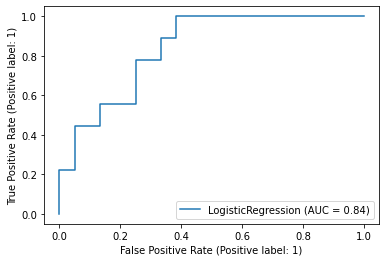

In [34]:
Xt_best = dft[df_best.iloc[0,3]].copy()
yt = dft['activity1'].copy()

best_model = model.fit(Xt_best, yt)
yt_pred = best_model.predict(Xt_best)

# plot ROC 
plot_roc_curve(best_model, Xt_best, yt) 

In [35]:
# calculate AUC
roc_auc_score(yt, best_model.predict_proba(Xt_best)[:, 1])

0.8388888888888889

In [36]:
# show the coefficients
model.coef_

array([[ 0.17784214,  0.21188366, -0.94461178, -0.2946096 , -0.15522421,
        -0.18524931,  0.15445825]])

In [37]:
# show the coefficients along with P-value
logit_model=sm.Logit(yt,Xt_best)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.289705
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              activity1   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:                  0.2518
Time:                        11:33:04   Log-Likelihood:                -19.990
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                   0.03634
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
max16          0.2267      0.232      0.978      0.328      -0.227       0.681
max21          0.4324      0.

<u>v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.</u>


In [39]:
# define a function to generate Test set with "l" cut
def l_test(l):
    
    # the number of each group
    n = math.floor(480/l)
    n1 = 480 - n*(l-1)
    ln = [n]*(l-1)
    ln.append(n1)
    
    ls_ = []
    for csv in range(len(ls)):
        name['s_'+ls[csv]+'l']=pd.Series({'activity0':ls[csv]})
        
        x = 0
        for i in range(l):
            # divide each instance into l parts
            name['d' + str(i)] = name[ls[csv]][x : (x + ln[i])].copy()
            name['d' + str(i)].index = range(ln[i])
            df=name['d' + str(i)].describe().rename(index={'25%':'1st_quart','50%':'median','75%':'3rd_quart'})
            
            # generate 6*6 time domain features for each part 
            # and append it to the series of this instance
            for j in range(1,7):
                idx=[item+str(i+1)+str(j) for item in ls_feature] # minj, maxj, meanj...
                name['s_'+str(i+1)+str(j)]=pd.Series(df.loc[ls_feature].iloc[:,j-1].tolist(),index=idx,name=j)
                name['s_'+ls[csv]+'l']=name['s_'+ls[csv]+'l'].append(name['s_'+str(i+1)+str(j)])
                
            x += ln[i]

    # generate the whole dataset
    df0_l=pd.DataFrame([name['s_'+ item +'l'] for item in ls]).sort_values('activity0',ignore_index=True)
    df0_l['activity']=df0['activity0'].map(lambda x:x.split('_')[0])
    df0_l['activity1']=df0['activity0'].map(lambda x:x.split('_')[1])
    
    # get the train
    Test0_l=df0_l[df0_l['activity0'].isin(['bending1_dataset1.csv','bending1_dataset2.csv',
                                     'bending2_dataset1.csv','bending2_dataset2.csv',
                                     'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv',
                                     'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv',
                                     'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv',
                                     'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv',
                                     'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv'])]

    Test_l=Test0_l.drop(columns=['activity0','activity1'])
    return Test_l

In [40]:
# get the test set
dfl_test = l_test(5)
df_test = ts(dfl_test, ls_n, ls_f)

df_test['activity1'] = df_test['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
df_test.drop(columns = 'activity',inplace = True)
        
Xtest = df_test[df_best.iloc[0,3]].copy()
ytest = df_test['activity1'].copy()

In [41]:
# calculate the test score
ytest_pred = best_model.predict(Xtest)
accuracy_score(ytest, ytest_pred)

0.7894736842105263

* __The accuracy score of test is 0.7895, the best accuracy score we attend in previous CV is 0.9198.__
* __Test score is lower than training cross validation score.__

<u>vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?<br/></u>

**The class of my dataset based on the features I chose before seems not well-seperated, thus the Logistic Regression converge normally, and there is no too much instability.**

<u>vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.</u>

In [42]:
# confusion matrix of test
pd.crosstab(ytest, ytest_pred)

col_0,0
activity1,
0,15
1,4


* __There does exist imbalanced classes in the confusion matrix. Thus, we can sampling the data to reach a balanced level.__

In [43]:
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(Xt_best, yt)
print(Xt_best.shape, yt.shape)
print(X_os.shape, y_os.shape)

(69, 7) (69,)
(120, 7) (120,)


In [44]:
best_model_os = model.fit(X_os, y_os)
yt_pred_os = best_model_os.predict(X_os)
ytest_pred_os = best_model_os.predict(Xtest)

# confusion matrix of train
pd.crosstab(y_os, yt_pred_os)

col_0,0,1
activity1,,
0,45,15
1,10,50


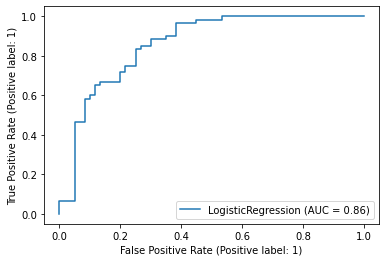

In [45]:
# plot ROC of train
plot_roc_curve(best_model_os, X_os, y_os) 

In [46]:
# calculate AUC of train
roc_auc_score(y_os, best_model_os.predict_proba(X_os)[:, 1])

0.8602777777777777

In [47]:
# confusion matrix of test
pd.crosstab(ytest, ytest_pred_os)

col_0,0,1
activity1,,
0,10,5
1,1,3


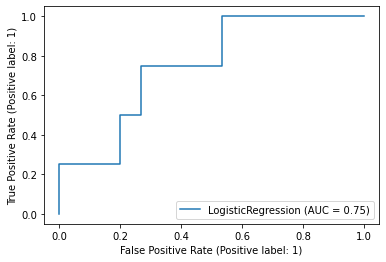

In [48]:
# plot ROC of test
plot_roc_curve(best_model_os, Xtest, ytest) 

In [49]:
# calculate AUC of test
roc_auc_score(ytest, best_model_os.predict_proba(Xtest)[:, 1])

0.7500000000000001

##### (b) Binary Classification Using L1-penalized logistic regression<br/>
<u>i. Repeat 4(a)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.</u>

In [50]:
# l = [1, 2,...,20]
l = range(1,21)

# the time series we want to extract from each instance
ls_n = [1, 2, 6]

# the time-domain features we want to extract 
ls_f = ['min', 'max', '3rd_quart']

lam = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ls_L1=[]
for i in l:
    dfl = l_train(i)
    dft = ts(dfl, ls_n, ls_f)
    dft['activity1'] = dft['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
    dft.drop(columns = 'activity',inplace = True)
        
    Xt = dft.drop(columns='activity1').copy()
    yt = dft['activity1'].copy()

    for j in lam:
        model = LogisticRegression(C = j, penalty = 'l1', solver = 'liblinear').fit(Xt, yt)

        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
        score1 = cross_val_score(model, Xt, yt,
                                 cv = kfold,
                                 scoring = 'accuracy')
        ls_L1.append([(i, j),score1.mean()])

In [51]:
df_L1 = pd.DataFrame(ls_L1, columns = ['(l,C)', 'accuracy']).sort_values('accuracy', ascending = False)
df_L1.head()

,"(l,C)",accuracy
59,"(9, 1)",0.941758
60,"(9, 10)",0.941758
33,"(5, 100)",0.941758
10,"(2, 1)",0.914286
32,"(5, 10)",0.914286


* __The best pair of $(l, C)$ is $(9, 1)$__

<u>ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?</u>

In [52]:
dfl = l_train(9)
dft = ts(dfl, ls_n, ls_f)
dft['activity1'] = dft['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
dft.drop(columns = 'activity',inplace = True)

Xt = dft.drop(columns='activity1').copy()
yt = dft['activity1'].copy()

best_l1_model = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear').fit(Xt, yt)

array([[-1.37398271e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.34866994e-01,  0.00000000e+00,
         4.03001320e-02,  3.93825053e-01,  0.00000000e+00,
         0.00000000e+00, -8.61864977e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.90583049e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.16777828e-01,  0.00000000e+00,
        -3.18574055e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.57603995e-01,  0.00000000e+00,
         0.00000000e+00, -1.12862619e-02, -8.64980818e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [69]:
# get the test set
dfl_test = l_test(5)
df_test = ts(dfl_test, ls_n, ls_f)

df_test['activity1'] = df_test['activity'].map(lambda a : 1 if (a=='bending1')|(a=='bending2') else 0)
df_test.drop(columns = 'activity',inplace = True)
        
Xtest = df_test[df_best.iloc[0,3]].copy()
ytest = df_test['activity1'].copy()

# calculate the test accuracy score
ytest_pred_l1 = best_model_os.predict(Xtest)
accuracy_score(ytest, ytest_pred_l1)

0.6842105263157895

* From the P-value, we can conclude that "variable selection using p-values" is better.

##### (c) Multi-class Classification (The Realistic Case)<br/>
<u>i. Find the best l in the same way as you found it in 4(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.</u>

In [54]:
# l = [1, 2,...,20]
l = range(1,21)

# the time series we want to extract from each instance
ls_n = [1, 2, 6]

# the time-domain features we want to extract 
ls_f = ['min', 'max', '3rd_quart']

lam = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ls_L1_multi=[]
for i in l:
    dfl = l_train(i)
    dft = ts(dfl, ls_n, ls_f)
        
    Xt = dft.drop(columns='activity').copy()
    yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                         'sitting','lying','cycling'),(0,0,1,2,3,4,5))

    for j in lam:
        mmodel = LogisticRegression(multi_class='multinomial', C = j, penalty = 'l1', solver='saga').fit(Xt, yt)

        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
        score1 = cross_val_score(mmodel, Xt, yt,
                                 cv = kfold,
                                 scoring = 'accuracy')
        ls_L1_multi.append([(i, j),score1.mean()])

In [55]:
df_L1_multi = pd.DataFrame(ls_L1_multi, columns = ['(l,C)', 'accuracy']).sort_values('accuracy', ascending = False)
df_L1_multi.head()

,"(l,C)",accuracy
76,"(11, 1000)",0.608791
74,"(11, 10)",0.594505
10,"(2, 1)",0.593407
12,"(2, 100)",0.593407
11,"(2, 10)",0.593407


In [56]:
# fit the best multi-classification model
dfl = l_train(11)
dft = ts(dfl, ls_n, ls_f)

Xt = dft.drop(columns='activity').copy()
yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                     'sitting','lying','cycling'),(0,0,1,2,3,4,5))

m_best_l1_model = LogisticRegression(multi_class='multinomial', C = 100, penalty = 'l1', solver='saga').fit(Xt, yt)

In [57]:
# get the test set 
dfl_test = l_test(11)
df_test = ts(dfl_test, ls_n, ls_f)
        
Xtest = df_test.drop(columns='activity').copy()
ytest = df_test['activity'].copy().replace(('bending1','bending2','walking','standing',
                                            'sitting','lying','cycling'),(0,0,1,2,3,4,5))

# calculate the test score
m_ytest_pred = m_best_l1_model.predict(Xtest)
accuracy_score(ytest, m_ytest_pred)

0.631578947368421

* __The accuracy score of best "LogisticRegression" model for multi-class is 0.6316.__

**For multi-class classification problem, the confusion matrix is the 2-d cross-table of all the possible y. Each cell(a,b) stands for the number of instance who is belonging to a class and classified to b class. In other words, a-th row and b-th column entry indicates the number of samples with true label being a-th class and predicted label being b-th class.**

In [58]:
# confution matrix
pd.DataFrame(confusion_matrix(ytest, m_ytest_pred))

,0,1,2,3,4,5
0,1,0,1,0,2,0
1,0,3,0,0,0,0
2,0,0,2,1,0,0
3,0,0,1,2,0,0
4,0,0,2,0,1,0
5,0,0,0,0,0,3


**For multi-class classification problem, the ROC curves are multi-lines and each line stands for one class.**

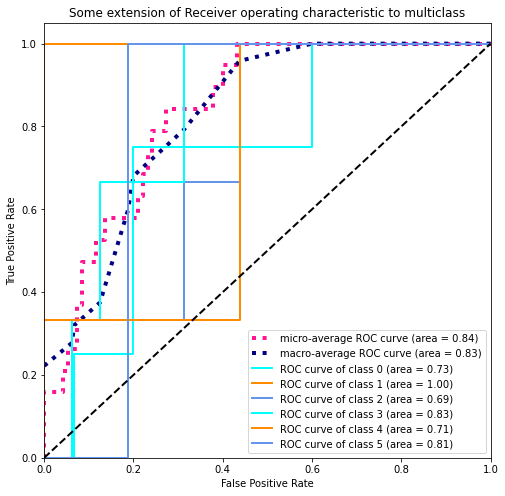

In [59]:
ytest_score_m = m_best_l1_model.decision_function(Xtest)
ytt = label_binarize(ytest, classes=[0, 1, 2,3,4,5])
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(ytt[:,i], ytest_score_m[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytt.ravel(), ytest_score_m.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(6):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 6

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

<u>ii. Repeat 4(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.</u>

In [60]:
# l = [1, 2,...,20]
l = range(1,21)

# the time series we want to extract from each instance
ls_n = [1, 2, 6]

# the time-domain features we want to extract 
ls_f = ['min', 'max', '3rd_quart']

smooth = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ls_multi_bayes=[]
for i in l:
    dfl = l_train(i)
    dft = ts(dfl, ls_n, ls_f)
        
    Xt = dft.drop(columns='activity').copy()
    yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                         'sitting','lying','cycling'),(0,0,1,2,3,4,5))

    for j in smooth:
        mmodel_bayes = GaussianNB(var_smoothing = j).fit(Xt, yt)

        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
        score1 = cross_val_score(mmodel_bayes, Xt, yt,
                                 cv = kfold,
                                 scoring = 'accuracy')
        ls_multi_bayes.append([(i, j),score1.mean()])

In [61]:
df_GB = pd.DataFrame(ls_multi_bayes, columns = ['(l,Smoothing)', 
                                                'accuracy']).sort_values('accuracy', ascending = False)
df_GB.head()

,"(l,Smoothing)",accuracy
1,"(1, 0.01)",0.768132
7,"(2, 0.001)",0.740659
0,"(1, 0.001)",0.738462
8,"(2, 0.01)",0.726374
21,"(4, 0.001)",0.710989


* __The best (l,Smoothing)	pair for "GaussianNB" is (1, 0.01).__

In [62]:
# fit the best multi-classification model ----> GaussianNB
dfl = l_train(1)
dft = ts(dfl, ls_n, ls_f)

Xt = dft.drop(columns='activity').copy()
yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                     'sitting','lying','cycling'),(0,0,1,2,3,4,5))

best_GB = GaussianNB(var_smoothing = 0.01).fit(Xt, yt)

In [63]:
# calculate the test accuracy ----> GaussianNB
# get the test set 
dfl_test = l_test(1)
df_test = ts(dfl_test, ls_n, ls_f)
        
Xtest = df_test.drop(columns='activity').copy()
ytest = df_test['activity'].copy().replace(('bending1','bending2','walking','standing',
                                            'sitting','lying','cycling'),(0,0,1,2,3,4,5))

# calculate the test error
ytest_pred_GB = best_GB.predict(Xtest)
accuracy_score(ytest, ytest_pred_GB)

0.7894736842105263

* __The accuracy score of best "GaussianNB" model is 0.7895.__

In [64]:
# find the best multi-classification model ----> MultinomialNB
smooth = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ls_multi_bayes=[]
for i in l:
    dfl = l_train(i)
    dft = ts(dfl, ls_n, ls_f)
        
    Xt = dft.drop(columns='activity').copy()
    yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                         'sitting','lying','cycling'),(0,0,1,2,3,4,5))

    for j in smooth:
        mmodel_bayes = MultinomialNB(alpha = j).fit(Xt, yt)

        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle = True)
        score1 = cross_val_score(mmodel_bayes, Xt, yt,
                                 cv = kfold,
                                 scoring = 'accuracy')
        ls_multi_bayes.append([(i, j),score1.mean()])

In [65]:
df_MNB = pd.DataFrame(ls_multi_bayes, columns = ['(l,Alpha)', 
                                                'accuracy']).sort_values('accuracy', ascending = False)
df_MNB.head()

,"(l,Alpha)",accuracy
86,"(13, 0.1)",0.695604
29,"(5, 0.01)",0.694505
31,"(5, 1)",0.694505
30,"(5, 0.1)",0.694505
84,"(13, 0.001)",0.682418


* __The best (l,Alpha)	pair for "MultinomialNB" is (13, 0.1).__

In [66]:
# fit the best multi-classification model ----> MultinomialNB
dfl = l_train(13)
dft = ts(dfl, ls_n, ls_f)

Xt = dft.drop(columns='activity').copy()
yt = dft['activity'].copy().replace(('bending1','bending2','walking','standing',
                                     'sitting','lying','cycling'),(0,0,1,2,3,4,5))

best_MNB = MultinomialNB(alpha = 0.1).fit(Xt, yt)

In [67]:
# calculate the test accuracy ----> MultinomialNB
# get the test set 
dfl_test = l_test(13)
df_test = ts(dfl_test, ls_n, ls_f)
        
Xtest = df_test.drop(columns='activity').copy()
ytest = df_test['activity'].copy().replace(('bending1','bending2','walking','standing',
                                            'sitting','lying','cycling'),(0,0,1,2,3,4,5))

# calculate the test error
ytest_pred_MNB = best_MNB.predict(Xtest)
accuracy_score(ytest, ytest_pred_MNB)

0.631578947368421

* __The accuracy score of best "MultinomialNB" model is 0.6316.__

<u>iii. Which method is better for multi-class classification in this problem?</u>

* __According to the results above, GaussianNB is better for multi-class classification in this problem.__